In [1]:
import sys
import numpy as np
import spectral as sp
import matplotlib as mpl
import matplotlib.pyplot as plt

sys.path.append('../')
from preprocessing import *
from extinctions import *
from plotting_parameters import *

In [2]:
bands_range = [520,900]
band_centers = np.arange(bands_range[0], bands_range[1]+1)

extinction_dict = get_extinctions(bands_range)
cyt_c_ox = extinction_dict["cyt_c_ox"]
cyt_c_red = extinction_dict["cyt_c_red"]
cyt_b_ox = extinction_dict["cyt_b_ox"]
cyt_b_red = extinction_dict["cyt_b_red"]
cyt_oxi_ox = extinction_dict["cyt_oxi_ox"]
cyt_oxi_red = extinction_dict["cyt_oxi_red"]
hb = extinction_dict["hb"]
hbo2 = extinction_dict["hbo2"]
water = extinction_dict["water"]
fat = extinction_dict["fat"]
scatter_simple = (band_centers/500)**(-1.2)

endmember_labels_scatter = ["oxCytc", "redCytc", "oxCytb", "redCytb", "oxCCO", "redCCO", "HHb", "HbO$_2$", "water", "lipids", "a'"]
M_scatter_simple = np.vstack((cyt_c_ox, cyt_c_red, cyt_b_ox, cyt_b_red, cyt_oxi_ox, cyt_oxi_red, hb, hbo2, water, fat, scatter_simple)).T
M_scatter_simple_smooth = smooth_spectral(M_scatter_simple.T,5).T

/home/martin_ivan/anaconda3/envs/thesis/lib/python3.10/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


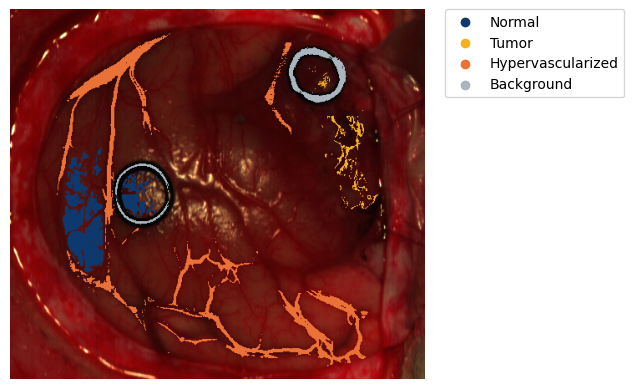

In [3]:
data_folder = "../../datasets/helicoid/012-01"
# data_folder = "../../datasets/helicoid/008-01"

class_labels = ["Not labled", "Normal", "Tumor", "Hypervascularized", "Background"]
class_colors = ["white", tum_blue_dark_2, tum_orange, tum_red, tum_grey_5]

# Load the sp data
img = sp.open_image(data_folder + "/raw.hdr")
white_ref = sp.open_image(data_folder + "/whiteReference.hdr")
dark_ref = sp.open_image(data_folder + "/darkReference.hdr")
gt_map = sp.open_image(data_folder + "/gtMap.hdr")
plot_img(img, gt_map, class_labels, class_colors, figsize=(5,5), legend=True)

# preprocessing
img_interp, band_centers = bands_lin_interpolation(img, img.bands.centers, bands_range)
white_ref_interp, _ = bands_lin_interpolation(white_ref, img.bands.centers, bands_range)
dark_ref_interp, _ = bands_lin_interpolation(dark_ref, img.bands.centers, bands_range)
img_calib = calibrate_img(img_interp, white_ref_interp, dark_ref_interp)
img_calib_norm = img_calib / np.linalg.norm(img_calib, axis=(0,1), ord=1, keepdims=True)
img_smooth = smooth_spectral(img_calib_norm, 5)
absorbance = -np.log(img_smooth - np.min(img_smooth.flatten()) + 1e-8)

(520.0, 900.0)

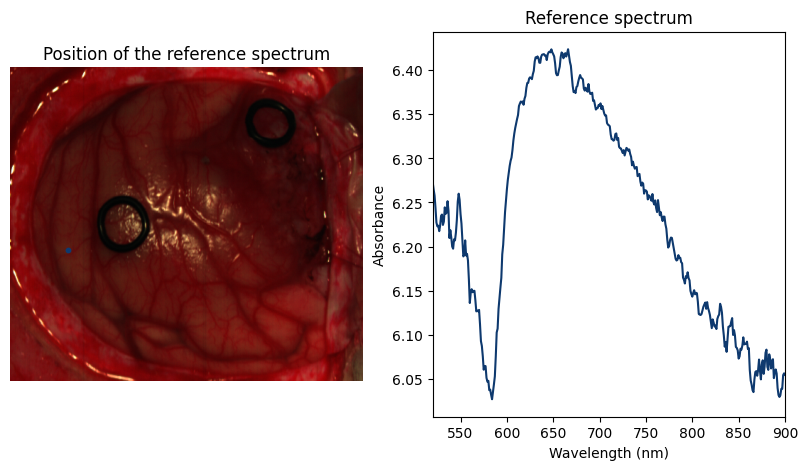

In [42]:
# select random spectrum from normal class
np.random.seed(0)
normal_idx = np.argwhere(gt_map.asarray() == 1)
random_idx = np.random.choice(normal_idx.shape[0])
reference_spectrum = absorbance[normal_idx[random_idx,0], normal_idx[random_idx,1], :]

# calculate absorbance difference between the selected spectrum and the rest of the image
delta_absorbance = absorbance - reference_spectrum[None,None,:]

# plot position of the selected spectrum on the image and the spectrum
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(get_rgb(img))
ax[0].scatter(normal_idx[random_idx,1], normal_idx[random_idx,0], c=tum_blue_dark_2, s=10)
ax[0].set_axis_off()
ax[0].set_title("Position of the reference spectrum")
ax[1].plot(band_centers, reference_spectrum, c=tum_blue_dark_2)
ax[1].set_title("Reference spectrum")
ax[1].set_xlabel("Wavelength (nm)")
ax[1].set_ylabel("Absorbance")
ax[1].set_xlim(bands_range)

## OSP

In [43]:
def osp(abs, endmembers_proj, endmember_target, device="cpu"):
    '''
    Project the image spectra in the subspace orthogonal to the spectra in endmembers_proj.
    input:
        abs: absorbance array to project, shape (...,k) where k is the number of bands and ... are the spatial or time dimensions
        endmembers_proj: endmember spectra to remove, shape (n, k), where n is the number of endmembers
        endmember_target: target endmember to detect, shape (k,)
    output:
        abs_proj: target heatmap, shape (...)
    '''
    P = np.eye(endmembers_proj.shape[1]) - endmembers_proj.T @ np.linalg.pinv(endmembers_proj).T
    # convert to torch tensors
    P = torch.from_numpy(P).to(device).float()
    abs = torch.from_numpy(abs).to(device).float()
    s = torch.from_numpy(endmember_target).to(device).float()
    # project data
    abs_proj = torch.einsum('ik,...k->...i', P, abs)
    # calculate target heatmap
    abs_proj = torch.einsum('k,...k->...', s, abs_proj).cpu().numpy()
    return abs_proj

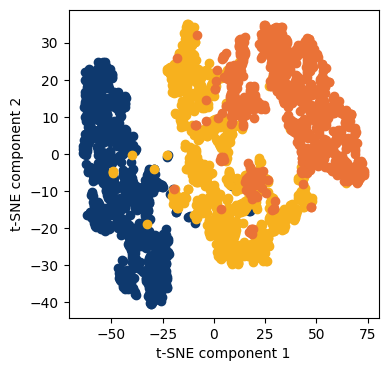

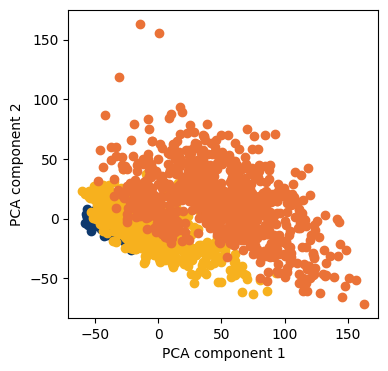

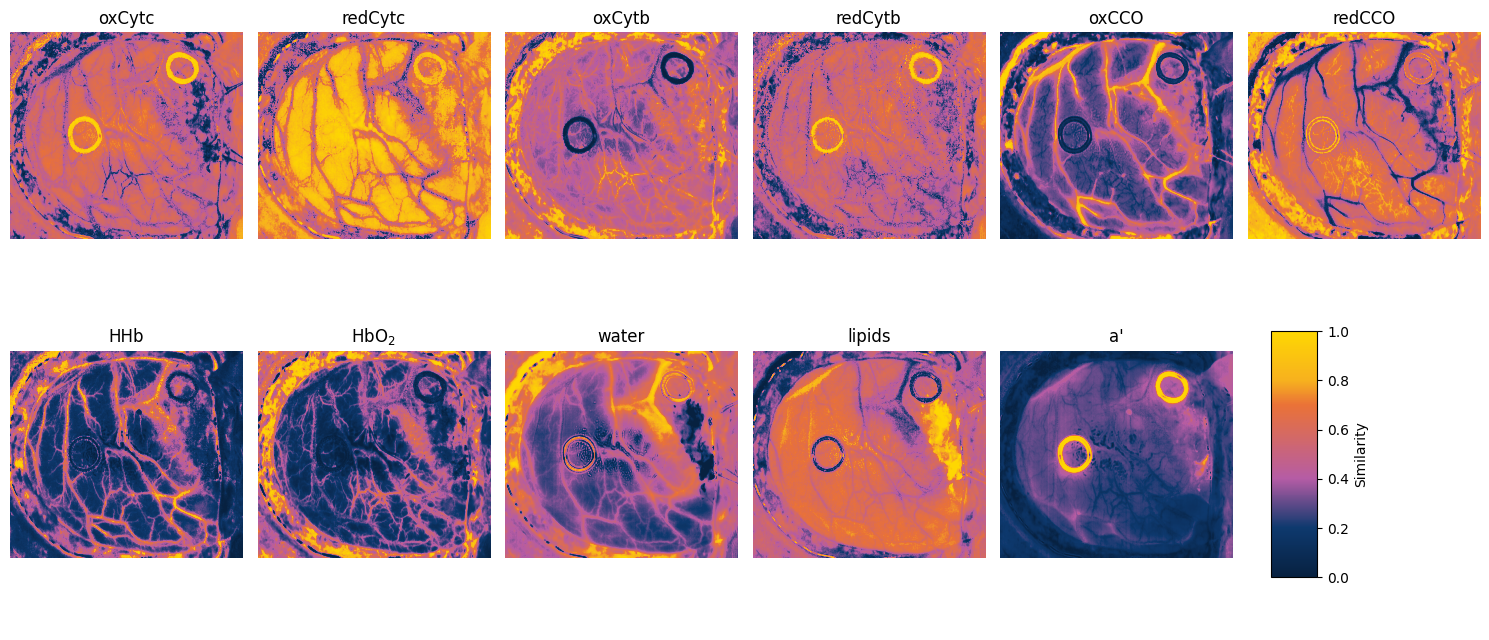

In [44]:
n = M_scatter_simple_smooth.shape[1]
l, m, k = delta_absorbance.shape
data = np.zeros((l,m,n))
for i in range(n):
    endmembers_remove = np.delete(M_scatter_simple_smooth, i, axis=1).T
    endmember_target = M_scatter_simple_smooth[:,i]
    data[:,:,i] = osp(delta_absorbance, endmembers_remove, endmember_target)

plot_tsne(data, gt_map, class_labels, mode='equal', figsize=(4,4), legend_loc=None)
plot_pca(data, gt_map, class_labels, mode='equal', figsize=(4,4), legend_loc=None)
plot_concentrations(clip_data(data), endmember_labels_scatter, figsize=(15,7));

## NNLS

In [55]:
from pysptools.abundance_maps.amaps import NNLS

def nnls_2d(abs, M):
    abs_flat = abs.reshape(-1, abs.shape[-1])
    endmembers = M.T
    print(abs.shape, endmembers.shape)
    c = NNLS(abs_flat, endmembers)
    print(c.shape)
    c = c.reshape(abs.shape[0], abs.shape[1], M.shape[1])
    return c

(443, 497, 381) (11, 381)
(220171, 11)


/home/martin_ivan/code/helicoid_tests/../plotting_parameters.py:359: RuntimeWarning: invalid value encountered in divide
  c = (c - np.min(c, axis=(0,1), keepdims=True))/(np.max(c, axis=(0,1), keepdims=True) - np.min(c, axis=(0,1), keepdims=True))


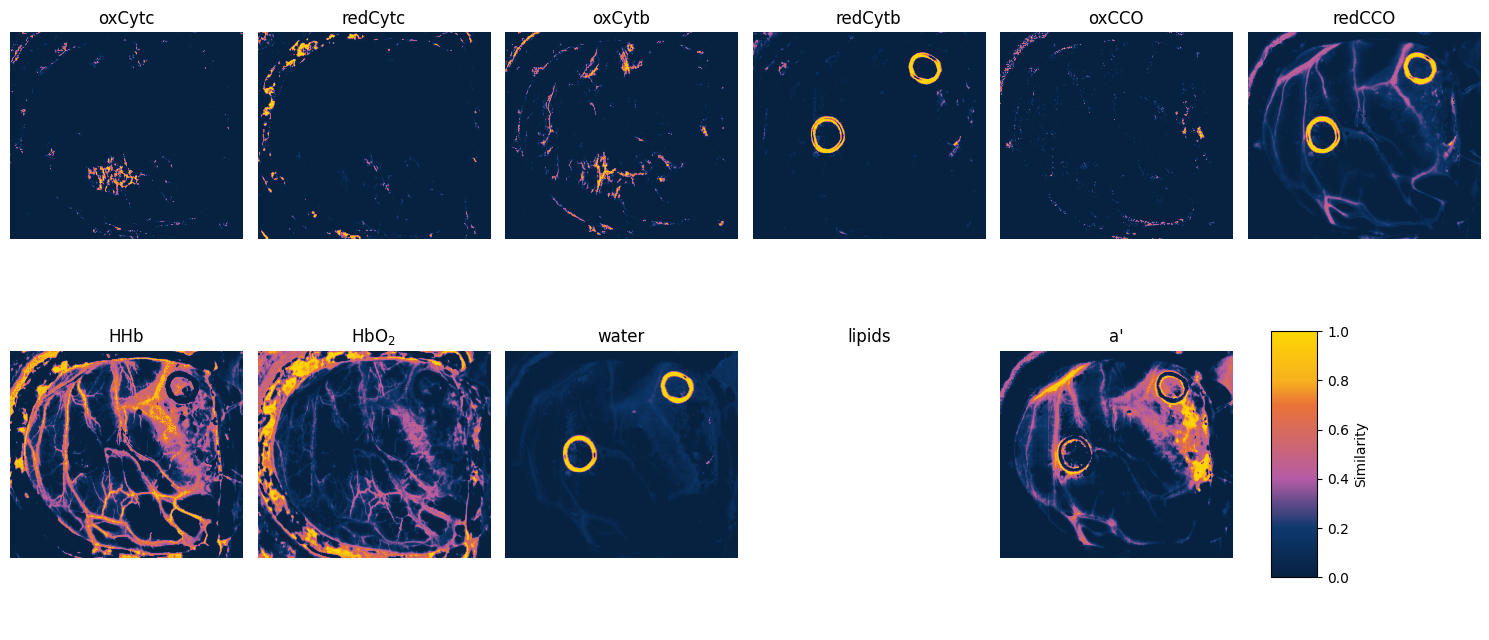

In [57]:
c = nnls_2d(delta_absorbance, M_scatter_simple_smooth)
plot_concentrations(clip_data(c), endmember_labels_scatter, figsize=(15,7));